<div align="center">
 <img alt="Deep Learning Indaba" src="https://gitlab.com/instadeep-public/grandchallenge/-/raw/master/dlindaba.jpg" />
    <h1>Grand Challenge</h1>
        <h2>Curing Leishmaniasis</h2>
    <br />
</div>

<h1> </h1>


This notebbok focuses on the evaluation of an arbitrary structure formed by a Leishmania protein (either from a defined species, or a protein present in the proteome of one or more of the Leishmania species) and a small molecule (ligand) which comes from a set of approved drugs.


Authors : Dr Marcin Skwark (m.skwark@instadeep.com) and Dr Nicolas Lopez Carranza (n.lopezcarranza@instadeep.com)


*This notebook is based on [PyRosetta](https://RosettaCommons.github.io/PyRosetta.notebooks) notebooks;
content is available [on Github](https://github.com/RosettaCommons/PyRosetta.notebooks.git).*
In order to run it, you need to install  [PyRosetta](http://www.pyrosetta.org/dow);

*Warning*: This notebook uses `pyrosetta.distributed.viewer` code, which runs in `jupyter notebook` and might not run if you're using `jupyterlab`. Consider installing `! jupyter labextension install jupyterlab_3dmol`

In [1]:
import logging
logging.basicConfig(level=logging.INFO)
import matplotlib
%matplotlib inline
import zipfile
import os
import pandas as pd
import pyrosetta
import pyrosetta.distributed.viewer as viewer
import seaborn
seaborn.set()
import sys
import requests
working_dir = os.getcwd()
DATA_FOLDER = './data'

ModuleNotFoundError: No module named 'pyrosetta'

The pdb files describing the possible targets for the Leishmania protein are stored in a (google bucket)[https://storage.googleapis.com/indaba-challenge/]. A useful (but not mandatory) tool to explore the bucket is (gsutil)[https://cloud.google.com/storage/docs/gsutil_install#mac]. For example we can list the contents of the bucket:

In [8]:
# Example of gsutil
# List all files
# !gsutil ls -r gs://indaba-challenge/*
# Copy a file locally
# !gsutil cp gs://indaba-challenge/A0A088RHB8.0.apo.pdb .

In the bucket there is a list of approved drugs. Lets download the zip folder containing the data of all the approved drugs and extracti it locally.

In [9]:
url = 'https://storage.googleapis.com/indaba-challenge/molecules.zip'
r = requests.get(url, allow_redirects=True)
open('molecules.zip', 'wb').write(r.content)

# # Extract all the files with 
with zipfile.ZipFile('molecules.zip', 'r') as zip_ref:
    zip_ref.extractall(DATA_FOLDER)

From the bucket, lets pick as target protein `A0A088RHB8.0.apo` (88RHB8 Leishmania panamensis) and a particular drug we want to test (a.k.a ligand, compound). Lets pick [Erlotinib](https://pubchem.ncbi.nlm.nih.gov/compound/176870) `AAKJLRGGTJKAMG-UHFFFAOYSA-N`. You can search for compounds [here](https://www.ncbi.nlm.nih.gov/pccompound/?term=AAKJLRGGTJKAMG-UHFFF) and check if they are in the zip file.

In [10]:
target_protein = 'A0A088RHB8.0.apo'
target_protein_file = '{}/{}.pdb'.format(DATA_FOLDER, target_protein)

url = 'https://storage.googleapis.com/indaba-challenge/{}.pdb'.format(target_protein)
r = requests.get(url, allow_redirects=True)
open(target_protein_file, 'wb').write(r.content)



333562

In [11]:
compound = 'AAKJLRGGTJKAMG-UHFFFAOYSA-N'
ligand_params = "{}/{}.params".format(DATA_FOLDER,compound)
ligand_file = "{}/{}.pdb".format(DATA_FOLDER,compound)

Now that we have our ligand and target structure we need to create poses with rosetta and create a target-ligand pose by appending the receptor protein and the ligand (drug). The [Pose](https://www.rosettacommons.org/manuals/latest/core+protocols/d3/d3c/classcore_1_1pose_1_1_pose.html#details) class in Rosetta represents a molecular system (protein-ligand) as a container of Residues. 

We also need the [params](https://www.rosettacommons.org/docs/latest/rosetta_basics/file_types/Residue-Params-file) file for the ligand. Params files store a variety of chemical and geometric information used to define the shape and chemical connectivity of an amino acid building block or other small molecule. This will be useful to create our scoring function.

In [12]:
flags = f"""
-ignore_unrecognized_res 1
-extra_res_fa {ligand_params}
"""
pyrosetta.distributed.init(flags)
pose_ligand = pyrosetta.io.pose_from_file(filename=ligand_file)
pose = pyrosetta.io.pose_from_file(filename=target_protein_file)
pose.append_pose_by_jump(pose_ligand,pose.total_residue())

INFO:rosetta:core.import_pose.import_pose: {0} File './data/AAKJLRGGTJKAMG-UHFFFAOYSA-N.pdb' automatically determined to be of type PDB
INFO:rosetta:core.io.pose_from_sfr.PoseFromSFRBuilder: {0} [ WARNING ] discarding 2 atoms at position 1 in file ./data/AAKJLRGGTJKAMG-UHFFFAOYSA-N.pdb. Best match rsd_type:  LG1
INFO:rosetta:core.io.pose_from_sfr.PoseFromSFRBuilder: {0} [ WARNING ] can't find pose atom for file-residue 1 atom  C22 (trying to store temperature in PDBInfo)
INFO:rosetta:core.io.pose_from_sfr.PoseFromSFRBuilder: {0} [ WARNING ] can't find pose atom for file-residue 1 atom  O4  (trying to store temperature in PDBInfo)
INFO:rosetta:core.import_pose.import_pose: {0} File './data/A0A088RHB8.0.apo.pdb' automatically determined to be of type PDB
INFO:rosetta:core.conformation.Conformation: {0} [ WARNING ] missing heavyatom:  OXT on residue ALA:CtermProteinFull 255
INFO:rosetta:core.conformation.Conformation: {0} [ WARNING ] missing heavyatom:  CG  on residue GLN 348
INFO:rosetta

Rosetta can be used to predict the bound structure of a ligand and a target protein starting from unbound structures. This is what we are going to do. To achieve that, we need to define a [Rosetta Ligand docking protocol](https://www.rosettacommons.org/demos/latest/tutorials/Protein-Protein-Docking/Protein-Protein-Docking). This is a script that describes the docking and scoring.

In [13]:
xml = pyrosetta.rosetta.protocols.rosetta_scripts.XmlObjects.create_from_string("""
<ROSETTASCRIPTS>
  <SCOREFXNS>
    <ScoreFunction name="fa_standard" weights="ref2015.wts"/>
  </SCOREFXNS>
  <RESIDUE_SELECTORS>
    <Chain name="chX" chains="X"/>
  </RESIDUE_SELECTORS>
  <SIMPLE_METRICS>
    <RMSDMetric name="rmsd_chX" residue_selector="chX" reference_name="store_native" residue_selector_ref="chX" robust="true" rmsd_type="rmsd_all" />
  </SIMPLE_METRICS>
  <SCORINGGRIDS ligand_chain="X" width="25">
    <ClassicGrid grid_name="vdw" weight="1.0"/>
  </SCORINGGRIDS>
  <LIGAND_AREAS>
    <LigandArea name="docking_sidechain_X" chain="X" cutoff="6.0" add_nbr_radius="true" all_atom_mode="true" minimize_ligand="10"/>
    <LigandArea name="final_sidechain_X" chain="X" cutoff="6.0" add_nbr_radius="true" all_atom_mode="true"/>
    <LigandArea name="final_backbone_X" chain="X" cutoff="7.0" add_nbr_radius="false" all_atom_mode="true" Calpha_restraints="0.3"/>
  </LIGAND_AREAS>
  <INTERFACE_BUILDERS>
    <InterfaceBuilder name="side_chain_for_docking" ligand_areas="docking_sidechain_X"/>
    <InterfaceBuilder name="side_chain_for_final" ligand_areas="final_sidechain_X"/>
    <InterfaceBuilder name="backbone" ligand_areas="final_backbone_X" extension_window="3"/>
  </INTERFACE_BUILDERS>
  <MOVEMAP_BUILDERS>
    <MoveMapBuilder name="docking" sc_interface="side_chain_for_docking" minimize_water="true"/>
    <MoveMapBuilder name="final" sc_interface="side_chain_for_final" bb_interface="backbone" minimize_water="true"/>
  </MOVEMAP_BUILDERS>
  <MOVERS>
    <SavePoseMover name="spm" restore_pose="0" reference_name="store_native"/>
    <Transform name="transform" chain="X" box_size="20.0" move_distance="10" angle="360" initial_perturb="2" cycles="500" repeats="5" temperature="1000"/>
    <HighResDocker name="high_res_docker" cycles="9" repack_every_Nth="3" scorefxn="fa_standard" movemap_builder="docking"/>
    <FinalMinimizer name="final" scorefxn="fa_standard" movemap_builder="final"/>
  </MOVERS>
  <FILTERS>
      <LigInterfaceEnergy name="interfE" scorefxn="fa_standard" energy_cutoff="0.0" confidence="0"/>
      <SimpleMetricFilter name="rmsd_chX" metric="rmsd_chX" cutoff="999999." comparison_type="lt" confidence="0"/>
  </FILTERS>
  <PROTOCOLS>
    <Add mover="spm"/>
    <Add mover="transform"/>
    <Add mover="high_res_docker"/>
    <Add mover="final"/>
    <Add filter="interfE"/>
    <Add filter="rmsd_chX"/>
  </PROTOCOLS>
</ROSETTASCRIPTS>
""").get_mover("ParsedProtocol")

INFO:rosetta:protocols.rosetta_scripts.RosettaScriptsParser: {0} Generating XML Schema for rosetta_scripts...
INFO:rosetta:protocols.rosetta_scripts.RosettaScriptsParser: {0} ...done
INFO:rosetta:protocols.rosetta_scripts.RosettaScriptsParser: {0} Initializing schema validator...
INFO:rosetta:protocols.rosetta_scripts.RosettaScriptsParser: {0} ...done
INFO:rosetta:protocols.rosetta_scripts.RosettaScriptsParser: {0} Validating input script...
INFO:rosetta:protocols.rosetta_scripts.RosettaScriptsParser: {0} ...done
INFO:rosetta:protocols.rosetta_scripts.RosettaScriptsParser: {0} Parsed script:
<ROSETTASCRIPTS>
	<SCOREFXNS>
		<ScoreFunction name="fa_standard" weights="ref2015.wts"/>
	</SCOREFXNS>
	<RESIDUE_SELECTORS>
		<Chain chains="X" name="chX"/>
	</RESIDUE_SELECTORS>
	<SIMPLE_METRICS>
		<RMSDMetric name="rmsd_chX" reference_name="store_native" residue_selector="chX" residue_selector_ref="chX" rmsd_type="rmsd_all" robust="true"/>
	</SIMPLE_METRICS>
	<SCORINGGRIDS ligand_chain="X" width

Now we are ready to produce 5 global ligand docking trajectories (We could create as many as we like). Each of them will score differently.

In [14]:
scorefxn = pyrosetta.create_score_function("ref2015")
output_dir = "output"
os.chdir(working_dir)
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
os.chdir(output_dir)

df = pd.DataFrame()
for i in range(5):
    test_pose = pose.clone()
    xml.apply(test_pose)
    test_df = pd.DataFrame.from_records(dict(test_pose.scores), index=[i])
    df = df.append(test_df)
    test_pose.dump_pdb('{}_{}.pdb'.format(target_protein, str(i)))
os.chdir(working_dir)

INFO:rosetta:protocols.rosetta_scripts.ParsedProtocol: {0} =======================BEGIN MOVER SavePoseMover - spm=======================
INFO:rosetta:protocols.rosetta_scripts.ParsedProtocol: {0} =======================BEGIN MOVER Transform - transform=======================
INFO:rosetta:protocols.qsar.scoring_grid.GridManager: {0} [ WARNING ] option -qsar:grid_dir is not set.  Use this flag to specify a directory to store scoring grids.  This will save you a huge amount of time
INFO:rosetta:protocols.qsar.scoring_grid.GridManager: {0} No conformation matching hash: 8b5b0bec11bd4fa62f5b9eafcc898f4a1088dce9 Updating grid and adding it to the cache
INFO:rosetta:protocols.ligand_docking.Transform: {0} Considering 1 conformers during sampling
INFO:rosetta:protocols.ligand_docking.Transform: {0} percent acceptance: 234 0.0936 2266
INFO:rosetta:protocols.ligand_docking.Transform: {0} Moves rejected for being outside of grid: 2264  0.9056
INFO:rosetta:protocols.ligand_docking.Transform: {0} [

Now that we have sampled some global ligand docking trajectories, let's plot the ligand binding energy landscape. The less interface energy the better drug target we found:

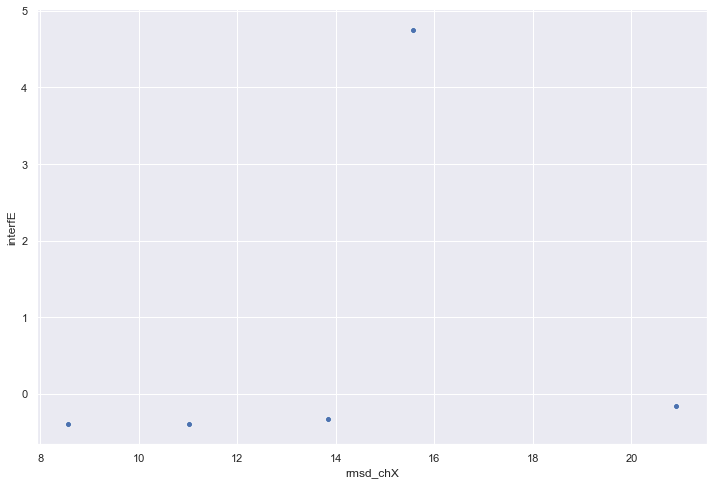

In [15]:
matplotlib.rcParams['figure.figsize'] = [12.0, 8.0]
seaborn.scatterplot(x="rmsd_chX", y="interfE", data=df)

We can check which `.pdb` file has the lowest `interfE` score:

In [16]:
df.sort_values(by="interfE")

,dslf_fa13,fa_atr,fa_dun,fa_elec,fa_intra_rep,fa_intra_sol_xover4,fa_rep,fa_sol,hbond_bb_sc,hbond_lr_bb,...,interfE,lk_ball_wtd,omega,p_aa_pp,pro_close,rama_prepro,ref,rmsd_chX,total_score,yhh_planarity
3,0.0,-3237.080314,1505.983684,-730.717798,7058.180675,114.341850,869.774721,1865.658983,-70.855462,-101.797820,...,-0.392392,-74.319553,264.665225,-128.229667,51.418746,2.670952,213.48252,11.025477,-612.052443,0.000034
4,0.0,-3237.529542,1502.226064,-728.560452,6266.938555,114.684920,865.480757,1866.040917,-69.873213,-100.668399,...,-0.391317,-76.096673,210.069772,-124.309490,51.576547,0.652502,213.48252,8.556891,-638.609446,0.004861
1,0.0,-3226.217891,1560.290808,-722.587671,5188.052062,116.339628,872.043144,1862.807850,-69.556331,-100.964823,...,-0.325532,-74.570377,210.120810,-122.275578,51.612632,2.351033,213.48252,13.837251,-580.886830,0.000000
0,0.0,-3214.873129,1462.495323,-743.461982,4982.557343,111.919390,841.912972,1866.523004,-74.299648,-100.849472,...,-0.155451,-77.966172,208.506698,-123.751986,45.397760,-2.087833,213.48252,20.904312,-700.961553,0.008565
2,0.0,-3225.070761,1532.216490,-743.313721,5073.127429,112.665576,821.303427,1862.850615,-75.163666,-101.117506,...,4.750016,-74.938267,203.805497,-125.440234,51.155471,1.275953,213.48252,15.561552,-663.258271,0.009691


Let's take a look at the pose with the lowest `interfE` value that was generated:

In [18]:
#Skip for tests
lowest_energy_pdb_filename = './{}/{}_{}.pdb'.format(output_dir,target_protein, str(df.sort_values(by="interfE").head(1).index[0])) 
# os.path.join("output", str(df.sort_values(by="interfE").head(1).index[0]))
print(lowest_energy_pdb_filename)
test_pose = pyrosetta.io.pose_from_file(filename=lowest_energy_pdb_filename)

chE = pyrosetta.rosetta.core.select.residue_selector.ChainSelector("E")

view = viewer.init(test_pose)
view.add(viewer.setStyle())
view.add(viewer.setStyle(command=({"hetflag": True}, {"stick": {"colorscheme": "brownCarbon", "radius": 0.2}})))
view.add(viewer.setSurface(residue_selector=chE, opacity=0.7, color='white'))
view.add(viewer.setHydrogenBonds())
view()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

If you think you achieved a good candidate, upload the pdb file to [Zindi](https://zindi.africa/competitions/indaba-grand-challenge-curing-leishmaniasis). You might be curing a Neglected Tropical Disease.

*Your turn:*

Re-run the above example with more sampling and with a different receptor protein and ligand (drug).

***
*Restart Jupyter Notebook kernel to properly re-initialize PyRosetta*
***